# A5 Convolutional Neural Networks

*Ethan Seefried*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A5-Convolutional-Neural-Networks" data-toc-modified-id="A5-Convolutional-Neural-Networks-1">A5 Convolutional Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Simple-Images" data-toc-modified-id="Simple-Images-1.1">Simple Images</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1.2">Requirements</a></span><ul class="toc-item"><li><span><a href="#Plus,-Minus,-Times,-Divide" data-toc-modified-id="Plus,-Minus,-Times,-Divide-1.2.1">Plus, Minus, Times, Divide</a></span></li><li><span><a href="#Real-Images-from-CIFAR-10" data-toc-modified-id="Real-Images-from-CIFAR-10-1.2.2">Real Images from CIFAR-10</a></span></li></ul></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2">Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3">Extra Credit</a></span></li></ul></div>

For this assignment, use the `ConvNet` class defined for you in Lecture Notes 13.  Cut and paste the contents of the `ConvNet` code cell into a file named `convnet.py`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time

import convnet

## Simple Images

Here is a function that generates a simple, fun, data set consisting of four classes of image that we can call `plus`, `minus`, `times` and `divide`.

In [2]:
def make_images(n_each_class):

    n_samples = n_each_class * 4
    
    images = np.zeros((n_samples, 20, 20))  # nSamples, rows, columns
    labels = np.zeros(n_samples)
    label_names = ['plus', 'minus', 'times', 'divide']
    
    radii = 3 + np.random.randint(10 - 5, size=(n_samples, 1))
    centers = np.zeros((n_samples, 2))
    
    for sample_i in range(0, n_samples, 4):
        r = radii[sample_i, 0]
        centers[sample_i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[sample_i, 0])
        y = int(centers[sample_i, 1])
        
        for class_i in range(4):
            
            if class_i == 0:
                # plus
                images[sample_i, x - r:x + r, y] = 1.0
                images[sample_i, x, y - r:y + r] = 1.0
                labels[sample_i] = 0

            elif class_i == 1:
                # minus
                images[sample_i + 1, x, y - r:y + r] = 1.0
                labels[sample_i + 1] = 1

            elif class_i == 2:
                # times
                images[sample_i + 2, range(x - r, x + r), range(y - r, y + r)] = 1.0
                images[sample_i + 2, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
                labels[sample_i + 2] = 2

            else:  # class_i == 3
                # divide
                images[sample_i + 3, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
                labels[sample_i + 3] = 3

    n, r, c = images.shape
    images = images.reshape(n, r, c)  # add channel dimension
    return images, labels, label_names

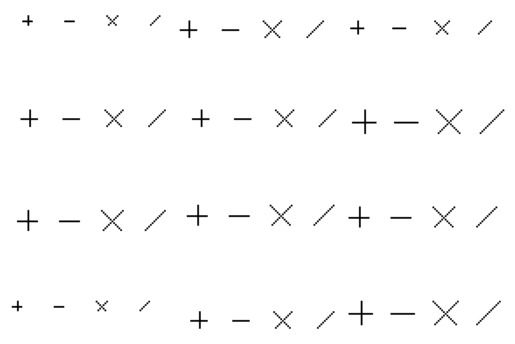

In [3]:
n_each_class = 12

X, T, label_names = make_images(n_each_class)

p = 0
for i in range(X.shape[0]):
    p += 1
    plt.subplot(4, 4 * 3, p)
    plt.imshow(-X[i, :, :], cmap='gray')
    plt.axis('off')

Let's make 500 samples in each class and train our convolutional neural net on this data. Remember to add the channel dimension, of size 1, because we have just one intensity per pixel.  

In [4]:
n_each_class = 500
X, T, label_names = make_images(n_each_class)
X = X.reshape(-1, 1, 20, 20)

We will train on the first 80% of the samples, validate on the next 10% and test on the remaining 10%.

In [5]:
n_samples = X.shape[0]
ntrain = int(n_samples * 0.8)
nval = int(n_samples * 0.1)

Xtrain = X[:ntrain, ...]
Ttrain = T[:ntrain]

Xval = X[ntrain:ntrain + nval, ...]
Tval = T[ntrain:ntrain + nval]
         
Xtest = X[ntrain + nval:, ...]
Ttest = T[ntrain + nval:]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((1600, 1, 20, 20),
 (1600,),
 (200, 1, 20, 20),
 (200,),
 (200, 1, 20, 20),
 (200,))

In [6]:
input_shape = X.shape[1:]
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [5]
stride_per_conv_layer = [1]
n_hiddens_per_fc_layer = [10]
n_outputs = 4

batch_size = -1  # means we will not divide training data into batches while training
learning_rate = 0.01
method = 'adam'
n_epochs = 5
n_reps = 50

device = 'cpu'   # or 'cuda'
nnet = convnet.ConvNet(input_shape,
                       n_hiddens_per_conv_layer, 
                       n_hiddens_per_fc_layer,
                       n_outputs,
                       patch_size_per_conv_layer, 
                       stride_per_conv_layer, device=device)

Accuracy Train 100.0 Val 97.0 Test 97.0
Training took 0.48 minutes.


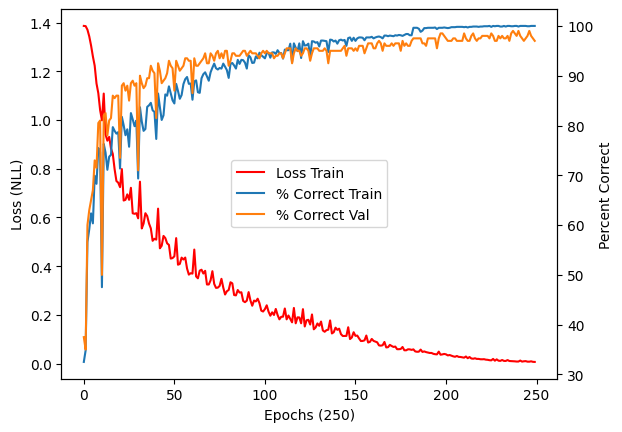

In [7]:
current_length = len(nnet.get_loss_trace())  # in case training existing net again

fig = plt.figure()
start_time = time.time()

for reps in range(n_reps):
    nnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
            Xval=Xval, Tval=Tval, verbose=False)

    plt.clf()
    ax = fig.add_subplot(111)
    loss_trace = nnet.get_loss_trace()
    plot1 = ax.plot(loss_trace, 'r-')
    ax.set_ylabel('Loss (NLL)')
    ax.set_xlabel('Epochs ({})'.format(current_length + n_reps * n_epochs))

    acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
    acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
    accuracies = nnet.get_accuracy_trace()
    xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

    ax2 = ax.twinx()
    plot2 = ax2.plot(xs, accuracies)
    ax2.set_ylabel('Percent Correct')

    plots = plot1 + plot2
    if len(plot2) == 1:
        ax.legend(plots, ('Loss Train', '% Correct Train'), loc='upper center')
    else:
        ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), loc='center')

    # plt.xlim(0, n_epochs * n_reps)
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
    
ipd.clear_output(wait=True)

acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
acc_val = nnet.percent_correct(nnet.use(Xval)[0], Tval)
acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
print('Accuracy Train', acc_train, 'Val', acc_val, 'Test', acc_test)

print('Training took {:.2f} minutes.'.format((time.time() - start_time)/60.0))

## Requirements

### Plus, Minus, Times, Divide

1. Run all of the above cells.
2. Draw at least 12 `Xtest` images that are correctly classified.  Use `plt.title` to specify the actual and predicted class names, using strings like `'{}\n{}'.format(label_names[Ttest[i]], label_names[Ytest[i]]`.
2. Draw some `Xtest` images that are incorrectly classified.  Again, title each image as you did in step 2.
3. Examine the weights in the first layer.  Draw the weights as images.  Do they make sense, given the kinds of images you are classifying? 
Try changing the network structure and retrain several times to try to make your weight images easier to interpret.

In [80]:
def draw_correct(Xtest):
    correct = []
    predictions, probs = nnet.use(Xtest) 
    for i in range(0, Ttest.size):
        if (predictions[i] == Ttest[i]):
            correct.append(Ttest[i])
    correct = np.array(correct)
    j = 0
    plt.figure(figsize=(20,20))
    for i in range(0,20):
        j += 1
        plt.subplot(20, 10, j)
        plt.imshow(-Xtest[i, 0, :, :], cmap='gray')
        plt.axis('off')
        plt.title("{}\n({})".format(label_names[int(Ttest[i])], label_names[int(predictions[i])]),color="blue")
        plt.tight_layout()

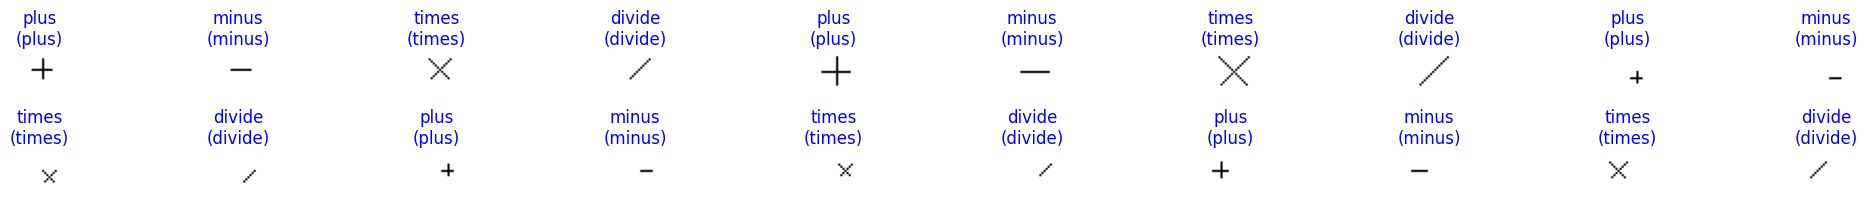

In [81]:
classes_s, props_s = nnet.use(Xtest) 
draw_correct(Xtest)

In [82]:
def draw_incorrect(Xtest):
    incorrect = []
    predictions, probs = nnet.use(Xtest) 
    for i in range(0, Ttest.size):
        if (predictions[i] != Ttest[i]):
            incorrect.append(Ttest[i])
    incorrect = np.array(incorrect)
    j = 0
    plt.figure(figsize=(20,20))
    for i in range(0, Ttest.size):
        if not Ttest[i] == predictions[i]:
            j += 1
            plt.subplot(20, 10, j)
            plt.imshow(-Xtest[i, 0, :, :], cmap='gray')
            plt.axis('off')
            plt.title("{}\n({})".format(label_names[int(Ttest[i])], label_names[int(predictions[i])]),color= "red")
            plt.tight_layout()

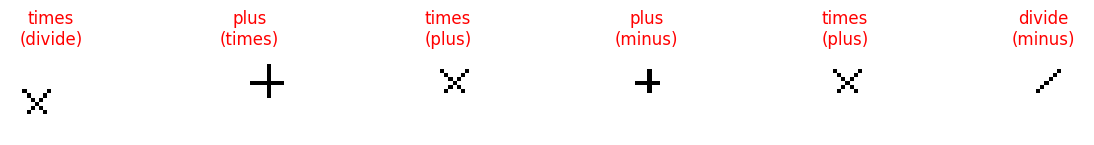

In [83]:
classes_s, props_s = nnet.use(Xtest) 
draw_incorrect(Xtest)

### Real Images from CIFAR-10

Download the `CIFAR-10 python version` data from [ Alex Krizhevsky's home page](https://www.cs.toronto.edu/~kriz/cifar.html).  Extract the data from the tar file and read the data using the following code.  We will take the first 5,000 images as training data, the next 5,000 as validation data, and the next 5,000 images as test data.

In [86]:
import pickle

with open('cifar-10-batches-py/batches.meta', 'rb') as f:
     d = pickle.load(f, encoding='bytes')

label_names = [z.decode() for z in d[b'label_names']]

X = []
T = []

for batch in ['data_batch_1', 'data_batch_2']:
    with open('cifar-10-batches-py/' + batch, 'rb') as f:
       d = pickle.load(f, encoding='bytes')

    X_batch = d[b'data']
    T_batch = np.array(d[b'labels'])

    X.append(X_batch)
    T.append(T_batch)
    
X = np.vstack(X)
T = np.hstack(T)

print(X.shape, T.shape)

X = X.reshape(-1, 3, 32, 32)
# T = T.reshape(-1, 1)

n_train = 5000
n_val = 5000
n_test = 5000

first = 0
last = n_train + first
Xtrain = X[first:last, ...]
Ttrain = T[first:last]

first = last
last = last + n_val
Xval = X[first:last, ...]
Tval = T[first:last, ...]

first = last
last = last + n_test
Xtest = X[first:last, ...]
Ttest = T[first:last]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

(20000, 3072) (20000,)


((5000, 3, 32, 32),
 (5000,),
 (5000, 3, 32, 32),
 (5000,),
 (5000, 3, 32, 32),
 (5000,))

In [87]:
def run_experiment(n_hiddens_per_conv_layer,
                   patch_size_per_conv_layer,
                   stride_per_conv_layer,
                   n_hiddens_per_fc_layer,
                   batch_size,
                   learning_rate,
                   method,
                   n_epochs,
                   n_reps,
                   device):
    
    input_shape = [3, 32, 32]
    n_outputs = 10

    nnet = convnet.ConvNet(input_shape,
                           n_hiddens_per_conv_layer, 
                           n_hiddens_per_fc_layer,
                           n_outputs,
                           patch_size_per_conv_layer, 
                           stride_per_conv_layer, device=device)


    current_length = len(nnet.get_loss_trace())

    fig = plt.figure()
    start_time = time.time()

    for reps in range(n_reps):
        nnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
                Xval=Xval, Tval=Tval, verbose=False)
        plt.clf()
        ax = fig.add_subplot(111)
        loss_trace = nnet.get_loss_trace()
        plot1 = ax.plot(loss_trace, 'r-')
        ax.set_ylabel('Loss (NLL)')
        ax.set_xlabel('Epochs ({})'.format(current_length + n_reps * n_epochs))

        acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
        acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
        accuracies = nnet.get_accuracy_trace()
        xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

        ax2 = ax.twinx()
        plot2 = ax2.plot(xs, accuracies)
        ax2.set_ylabel('Percent Correct')

        plots = plot1 + plot2
        if len(plot2) == 1:
            ax.legend(plots, ('Loss Train', '% Correct Train'), loc='upper center')
        else:
            ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), 
                      loc='upper center')

        # plt.xlim(0, n_epochs * n_reps)

        ipd.clear_output(wait=True)
        ipd.display(fig)

    ipd.clear_output(wait=True)

    acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
    acc_val = nnet.percent_correct(nnet.use(Xval)[0], Tval)
    acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
    print('Accuracy Train', acc_train, 'Val', acc_val, 'Test', acc_test)

    print('Training took {:.2f} minutes.'.format((time.time() - start_time)/60.0))
    
    return acc_train, acc_val, acc_test, nnet

Accuracy Train 86.66 Val 33.82 Test 34.339999999999996
Training took 11.54 minutes.


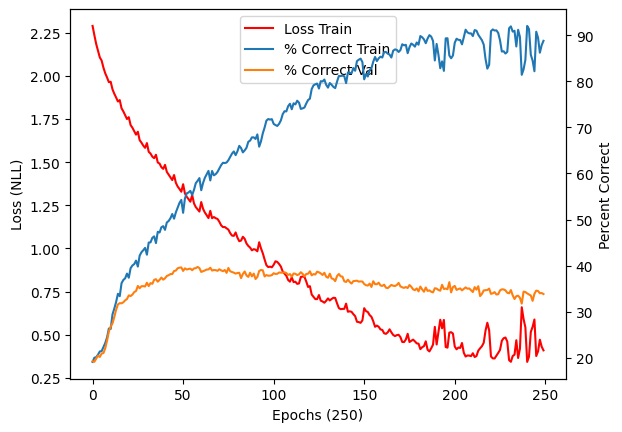

In [88]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10, 10],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

5. Perform additional experiments with the CIFAR-10 data to investigate these questions:
    1. Do more or fewer layers of convolutional units work better?
    2. How well does a network without convolutional layers work on this data?
    3. Do more or fewer layers of fully-connected units work better?
    4. How well does a network without fully connected layers work on this data?
    3. For what cases do you see overfitting occurring?
6. Examine the weights in the first layer.  Draw the weights as images.  Do they make sense, given the kinds of images you are classifying? 

Accuracy Train 50.2 Val 41.6 Test 41.58
Training took 17.21 minutes.


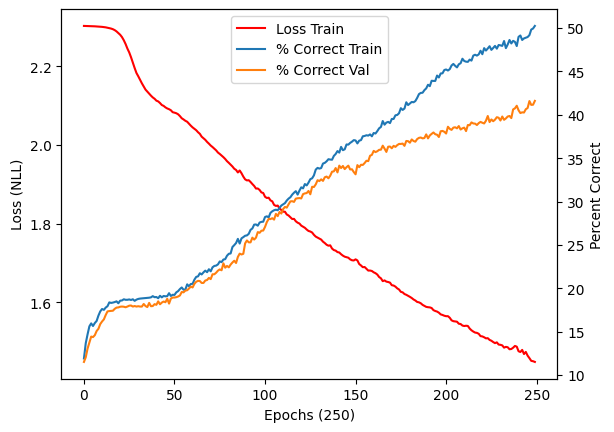

In [91]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[20, 20],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='sgd',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

Accuracy Train 40.18 Val 23.96 Test 24.12
Training took 2.40 minutes.


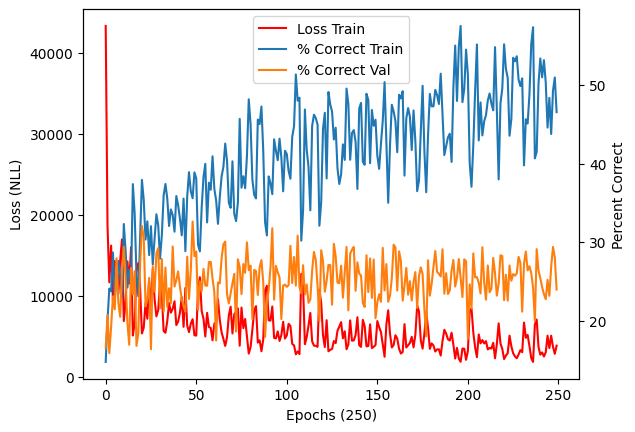

In [93]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[],
    patch_size_per_conv_layer=[],
    stride_per_conv_layer=[],
    n_hiddens_per_fc_layer=[],
    batch_size=200,
    learning_rate=0.001,
    method='sgd',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

Accuracy Train 57.4 Val 43.78 Test 42.44
Training took 27.74 minutes.


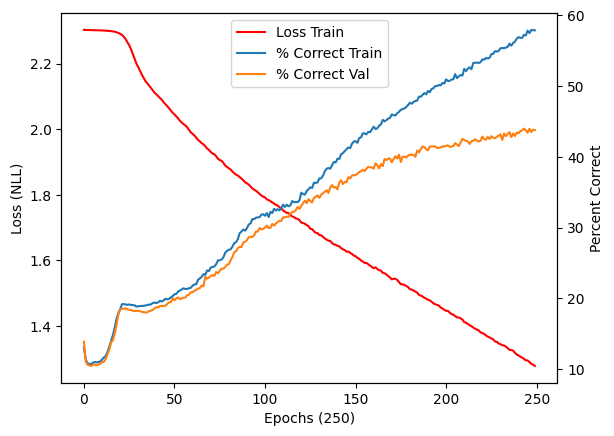

In [96]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[40, 40],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='sgd',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

Accuracy Train 94.88 Val 51.1 Test 51.019999999999996
Training took 26.40 minutes.


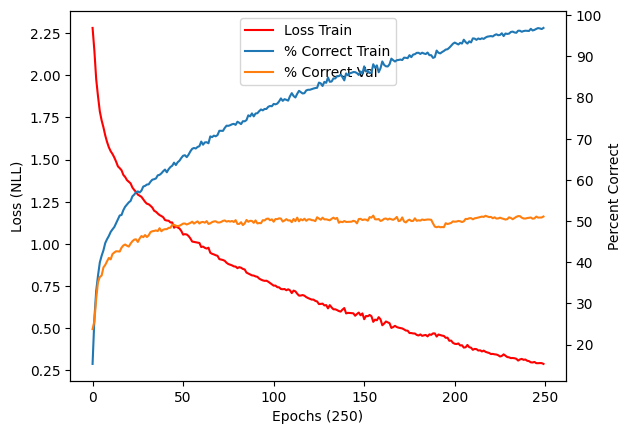

In [97]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[40, 40],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[],
    batch_size=200,
    learning_rate=0.0005,
    method='sgd',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

Accuracy Train 68.92 Val 47.22 Test 46.26
Training took 8.31 minutes.


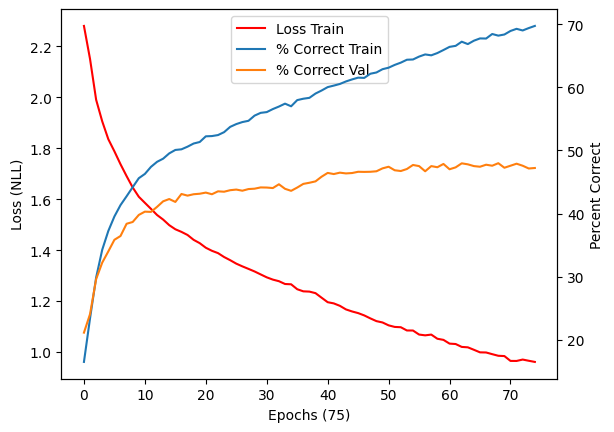

In [99]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[40, 40],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[],
    batch_size=200,
    learning_rate=0.0005,
    method='sgd',
    n_epochs=5,
    n_reps=15,
    device='cpu')   # or 'cuda'

Accuracy Train 99.72 Val 42.22 Test 41.620000000000005
Training took 8.14 minutes.


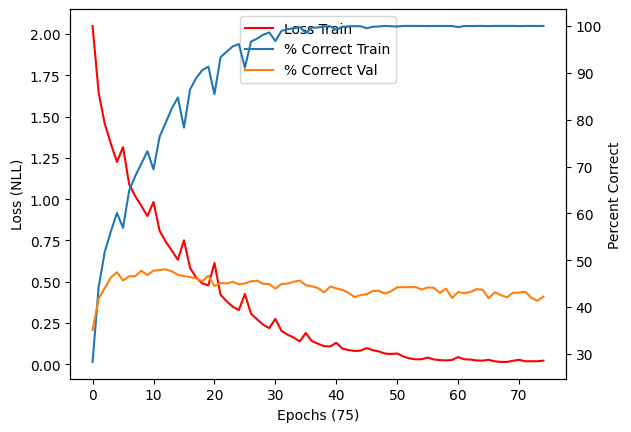

In [100]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[40, 40],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=15,
    device='cpu')   # or 'cuda'

# Grading

No grading script will be provided for this assignment.  Your grade will be based on how well you answer the stated questions.

# Extra Credit

Try using all of the CIFAR-10 data, meaning all six batches of data. Train and test your network on a GPU.  Report results, including training time.